# Worldmap

This notebook is based on a tutorial given by [@chdoig](https://github.com/chdoig/scipy2015-blaze-bokeh) about the Bokeh library at Scipy 2015's meeting.

In [1]:
'''
This module exposes geometry data for World Country Boundaries.
'''
import csv
import codecs
import gzip
import xml.etree.cElementTree as et
from os.path import dirname, join

nan = float('NaN')

data = {}
with gzip.open('data/World_Country_Boundaries.csv.gz') as f:
    decoded = codecs.iterdecode(f, "utf-8")
    next(decoded)
    reader = csv.reader(decoded, delimiter=',', quotechar='"')
    for row in reader:
        geometry, code, name = row
        xml = et.fromstring(geometry)
        lats = []
        lons = []
        for i, poly in enumerate(xml.findall('.//outerBoundaryIs/LinearRing/coordinates')):
            coords = (c.split(',')[:2] for c in poly.text.split())
            lats, lons = list(zip(*[(float(lat), float(lon)) for lon, lat in
                coords]))
            data[code + str(i)] = {
                'name'   : name,
                'lats'   : lats,
                'lons'   : lons,
            }

In [2]:
# Process data

In [3]:
import pandas as pd

world_countries = data.copy()
worldmap = pd.DataFrame.from_dict(world_countries, orient='index')
del world_countries

In [4]:
worldmap.head()

lons                  name  \
AD0           (1.451527, 1.723609, 1.738609, 1.445836)               Andorra   
AE0  (55.510273, 56.023673, 55.778954, 55.814027, 5...  United Arab Emirates   
AF0  (65.697545, 65.563045, 64.823045, 64.5036, 63....           Afghanistan   
AG0   (-61.670555, -61.829582, -61.881527, -61.738064)     Antigua & Barbuda   
AI0   (-63.053273, -63.168027, -62.992491, -62.973482)              Anguilla   

                                                  lats  
AD0       (42.446245, 42.509436, 42.616391, 42.601945)  
AE0  (23.972773, 24.083191, 24.243645, 24.885827, 2...  
AF0  (37.532564, 37.261318, 37.1386, 36.280545, 35....  
AG0       (17.088473, 17.165554, 17.022082, 16.989718)  
AI0       (18.259118, 18.164727, 18.227536, 18.272354)

In [82]:
worldmap.describe(include='all')

lons    name  \
count                                                 536     536   
unique                                                536     235   
top     (-16.455282, -16.115282, -16.349727, -16.24917...  Canada   
freq                                                    1      10   

                                                     lats   area  
count                                                 536  536.0  
unique                                                536   81.0  
top     (25.843327, 26.435, 27.046945, 27.568054, 28.2...    0.0  
freq                                                    1  191.0

In [5]:
from bokeh.plotting import output_notebook
# Output option
output_notebook()

Loading BokehJS ...

## First step, plain worldmap plot

Let's see what we have from `worldmap`.

In [6]:
from bokeh.plotting import figure

# Create your plot
p = figure(plot_height=500, plot_width=900, toolbar_location="left",
    x_axis_type=None, y_axis_type=None)

p.patches(xs=worldmap['lons'], ys=worldmap['lats'], fill_color="white", fill_alpha=0,
    line_color="black", line_width=0.5)

GlyphRenderer(id='a7265290-8172-44cc-abee-5de9d4be364f', ...)

In [7]:
from bokeh.plotting import show

# Show plot
show(p)

## Testing the presence of a point

Now I want to check whether a point is inside one of those countries.
In particular, I will use ``Brazil`` as (test) region to check whether a point is inside that region.
If we manage to properly deal with this question, then we'll have a little tool to cross-correlate spatial
data where regions are described by polygons and we need to verify for events inside those regions.

In [8]:
brmap = worldmap.loc[worldmap['name']=='Brazil']
brmap

lons    name  \
BR0  (-44.951391, -44.858891, -45.158755, -45.3507,...  Brazil   
BR1  (-50.814309, -50.723918, -50.579518, -50.05430...  Brazil   
BR2  (-51.901391, -51.276809, -51.198336, -51.5914,...  Brazil   
BR3  (-49.643618, -49.703891, -50.391946, -50.34986...  Brazil   
BR4     (-50.5625, -50.972782, -51.027227, -50.857782)  Brazil   
BR5     (-49.650982, -49.8525, -49.525555, -49.397809)  Brazil   
BR6   (-50.317782, -50.377782, -50.536391, -50.441118)  Brazil   
BR7               (-50.813609, -51.070282, -51.140009)  Brazil   
BR8               (-50.059864, -50.308064, -50.254173)  Brazil   
BR9               (-45.321946, -45.447918, -45.243336)  Brazil   

                                                  lats  
BR0  (-1.601664, -1.430627, -1.480418, -1.736809, -...  
BR1  (-1.329518, -1.510146, -1.798682, -1.708473, -...  
BR2  (-1.476664, -1.02, -0.530282, -0.724818, -0.73...  
BR3         (0.210282, 0.335, 0.189718, 0.021809, 0.0)  
BR4           (-0.054164, -0.09, -0.224164, -0.283055)  
BR5              (0.077364, -0.064446, -0.134446, 0.0)  
BR6           (0.308891, 0.618336, 0.222364, 0.171109)  
BR7                  (-0.576109, -0.694446, -0.962218)  
BR8                     (0.643054, 0.506391, 0.341945)  
BR9                 (-23.726946, -23.9175, -23.967227)

In [9]:
from matplotlib.path import Path
import numpy as np
regions_path = []
for lbl,row in brmap.iterrows():
    regions_path.append( Path( np.array(zip(row.lons,row.lats)) ) )

In [10]:
regions_path

[Path(array([[-44.951391,  -1.601664],
        [-44.858891,  -1.430627],
        [-45.158755,  -1.480418],
        [-45.3507  ,  -1.736809],
        [-45.324727,  -1.314718],
        [-45.462227,  -1.545555],
        [-45.446946,  -1.310836],
        [-45.696182,  -1.368682],
        [-45.735555,  -1.18    ],
        [-45.861527,  -1.259518],
        [-45.9757  ,  -1.0775  ],
        [-46.046673,  -1.210282],
        [-46.259446,  -1.177782],
        [-46.191946,  -0.9575  ],
        [-46.61    ,  -1.0375  ],
        [-46.601109,  -0.867782],
        [-46.826673,  -0.713191],
        [-46.96    ,  -0.898473],
        [-46.959727,  -0.702782],
        [-47.4314  ,  -0.5825  ],
        [-47.398064,  -0.812782],
        [-47.744591,  -0.637364],
        [-48.238064,  -0.867782],
        [-48.499727,  -1.461455],
        [-48.188964,  -1.466255],
        [-48.413609,  -1.499446],
        [-48.427227,  -1.660282],
        [-48.697227,  -1.469164],
        [-48.970491,  -1.840555],
        [

In [11]:
def region_contains_point(point, regions_path):
    contains = sum( reg.contains_point(point) for reg in regions_path )
    return contains > 0
point = (-67.9,-10) # Rio Branco, Acre
contains = region_contains_point(point,regions_path)
contains

True

OK. So now we know how to select a country and verify whether a point (pair of coordinates, longitude and latitude)
belongs to that country.
Let us generalize the workflow a set of points and a named country.

## Discretizing the longitude/latitude grid

Now I want to define regions in the (world)map such as regions are to be countries.
Such regions will be used in a second step as masks to filter data presented as (180,360) matrixes,
where each element of the matrix is a (1 square degree) region of the globe.

In [12]:
def generate_worldcoords_grid():
    '''
    Generate the coordinates matrix
    
    Such matrix represents 1 square-degree regions over the globe,
    (longitude,latitude) positions covering the whole range:
    ( [-179.5:1:179.5] , [-89.5:1:89.5] )
    '''
    lats = np.linspace(-89.5,89.5,180)
    lons = np.linspace(-179.5,179.5,360)
    grid = np.meshgrid(lons,lats)
    return grid
grid = generate_worldcoords_grid()
lon = grid[0]
lat = grid[1]

In [13]:
#print 'Shape:',grid[1].shape
print 'Longitude:\n',lon
print 'Latitude:\n',lat

Longitude:
[[-179.5 -178.5 -177.5 ...,  177.5  178.5  179.5]
 [-179.5 -178.5 -177.5 ...,  177.5  178.5  179.5]
 [-179.5 -178.5 -177.5 ...,  177.5  178.5  179.5]
 ..., 
 [-179.5 -178.5 -177.5 ...,  177.5  178.5  179.5]
 [-179.5 -178.5 -177.5 ...,  177.5  178.5  179.5]
 [-179.5 -178.5 -177.5 ...,  177.5  178.5  179.5]]
Latitude:
[[-89.5 -89.5 -89.5 ..., -89.5 -89.5 -89.5]
 [-88.5 -88.5 -88.5 ..., -88.5 -88.5 -88.5]
 [-87.5 -87.5 -87.5 ..., -87.5 -87.5 -87.5]
 ..., 
 [ 87.5  87.5  87.5 ...,  87.5  87.5  87.5]
 [ 88.5  88.5  88.5 ...,  88.5  88.5  88.5]
 [ 89.5  89.5  89.5 ...,  89.5  89.5  89.5]]


In [14]:
import pandas
coords = np.vstack( [lon.ravel(), lat.ravel()] ).T
coords = pandas.DataFrame(coords, columns=['lon','lat'])
coords.head()

lon   lat
0 -179.5 -89.5
1 -178.5 -89.5
2 -177.5 -89.5
3 -176.5 -89.5
4 -175.5 -89.5

In [15]:
def country_coords(country,worldmap):
    '''
    Given a country name, filter table' rows to matching country
    
    'countries_table' is expected to have a 'name' column,
    from where 'country' name will be searched for.
    '''
    country_map = worldmap.loc[worldmap['name']==country]
    assert len(country_map), "Country '{}' doesn't seem to exist".format(country)
    return country_map


def define_regions(country_map):
    '''
    Return a list of regions (~matplotlib.path.Path), for each entry in 'country_map'
    
    'country_map' is expected to provide columns 'lons' and 'lats',
    providing lists of coordinates defining the respective country
    as polygon(s). If 'country_map' has multiple lines, multiple
    "Paths" will be created (for each line/polygon).
    '''
    from matplotlib.path import Path
    import numpy as np
    regions_path = []
    for lbl,row in country_map.iterrows():
        regions_path.append( Path( np.array(zip(row.lons,row.lats)) ) )
    return regions_path

### Test country selection

Let's see whether we can retrieve the countries coordinates from table and how our "region" is defined.
Then, we will create a mask (a boolean version of our coordinates grid (180,360) matrix) to represent such country
is a bi-dimensional (our coordinates grid) matrix.

In [16]:
country_map = country_coords('Brazil',worldmap)
regions_path = define_regions(country_map)
regions_path

[Path(array([[-44.951391,  -1.601664],
        [-44.858891,  -1.430627],
        [-45.158755,  -1.480418],
        [-45.3507  ,  -1.736809],
        [-45.324727,  -1.314718],
        [-45.462227,  -1.545555],
        [-45.446946,  -1.310836],
        [-45.696182,  -1.368682],
        [-45.735555,  -1.18    ],
        [-45.861527,  -1.259518],
        [-45.9757  ,  -1.0775  ],
        [-46.046673,  -1.210282],
        [-46.259446,  -1.177782],
        [-46.191946,  -0.9575  ],
        [-46.61    ,  -1.0375  ],
        [-46.601109,  -0.867782],
        [-46.826673,  -0.713191],
        [-46.96    ,  -0.898473],
        [-46.959727,  -0.702782],
        [-47.4314  ,  -0.5825  ],
        [-47.398064,  -0.812782],
        [-47.744591,  -0.637364],
        [-48.238064,  -0.867782],
        [-48.499727,  -1.461455],
        [-48.188964,  -1.466255],
        [-48.413609,  -1.499446],
        [-48.427227,  -1.660282],
        [-48.697227,  -1.469164],
        [-48.970491,  -1.840555],
        [

In [17]:
coords['mask'] = coords.apply(lambda df: region_contains_point( [df.lat,df.lon], regions_path), axis=1)

In [18]:
coords.loc[coords['mask'] == True].head()

lon   lat  mask
5932 -7.5 -73.5  True
6291 -8.5 -72.5  True
6292 -7.5 -72.5  True
6293 -6.5 -72.5  True
6294 -5.5 -72.5  True

In [19]:
grid_mask = np.array(coords['mask'],dtype=bool).reshape(180,360)

In [20]:
coords_mask = np.where(grid_mask)
# coords_mask

In [21]:
lon_mask = lat[coords_mask[0],0]
# lon_mask

In [22]:
lat_mask = lon[0,coords_mask[1]]
# lat_mask

OK...we can get our coordinates back-and-forth.
Let's now filter a (fake) array at once.
Our _fake array_ will just be a list of integer (like the ``coords`` table index), we should,
for instance, get the same index shown above for the mask.

In [23]:
bla = np.array(coords.index, dtype=int).reshape(180,360)
# bla[grid_mask]

OK...looks like it works.
If we manage to draw those points on the World map, basically, everything is done.
Next step will then plot real data ;)

In [24]:
# Create your plot
p = figure(plot_height=500, plot_width=900, toolbar_location="left",
    x_axis_type=None, y_axis_type=None)

p.patches(xs=worldmap['lons'], ys=worldmap['lats'], fill_color="white", fill_alpha=0,
    line_color="black", line_width=0.5)

p.circle(lon_mask, lat_mask)

GlyphRenderer(id='7d727370-6fac-4e75-9058-d3279a5ac873', ...)

In [25]:
show(p)

## Coverage-weighed interactive plot

I should now go one step further into interactiveness and on handling various/all contries at once.
I'll plot every regaion filled with a color expressing the countries area.

In [26]:
countries_list = worldmap.name.unique()

### Compute countries area

In [27]:
def compute_countries_area(countries, worldmap):
    grid = generate_worldcoords_grid()
    lon = grid[0]
    lat = grid[1]
    import pandas
    coords = np.vstack( [lon.ravel(), lat.ravel()] ).T
    coords = pandas.DataFrame(coords, columns=['lon','lat'])

    areas = {}
    for country in countries:
        area_un = None
        if len(worldmap.name == country) > 0:
            country_map = country_coords( country, worldmap )
            regions_path = define_regions(country_map)
            coords['mask'] = coords.apply(lambda df: region_contains_point( [df.lat,df.lon], regions_path), axis=1)
            area_px = len(coords.loc[coords['mask'] == True])
            area_un = float(area_px)/len(coords)
        areas[country] = area_un
    return areas

In [28]:
import pandas
areas = pandas.read_csv('data/countriesarea.csv')
areas.head()

name      area
0     Canada  0.009568
1  Bouvet I.  0.000000
2  Lithuania  0.000139
3   Cambodia  0.000000
4   Ethiopia  0.001435

In [29]:
areas = { row['name']:row['area'] for ind,row in areas.iterrows() }

In [30]:
worldmap['area'] = None
for cn,ca in areas.iteritems():
    worldmap.loc[worldmap['name']==cn,'area'] = ca

In [31]:
def plot_worldmap_areas(country_names, worldmap):
    
    # Data source
    from bokeh.models import ColumnDataSource
    countrymap = worldmap.loc[worldmap['name'].isin(country_names)]

#     import numpy as np
#     weight = np.random.rand(len(countrymap))
#     countrymap['rate'] = weight
    
    source = ColumnDataSource(countrymap)
                              
    from bokeh.models import LogColorMapper,LinearColorMapper
    from bokeh.palettes import YlOrBr9 as palette
    palette.reverse()
    color_mapper = LogColorMapper(palette=palette)
#     color_mapper = LinearColorMapper(palette=palette)
    
    from bokeh.plotting import figure
    TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"
    p = figure( plot_height=500, plot_width=900,
                toolbar_location="left", tools=TOOLS,
                x_axis_type=None, y_axis_type=None)

    p.patches(xs=worldmap['lons'], ys=worldmap['lats'], fill_color="white", fill_alpha=0,
                line_color="black", line_width=0.2)

    p.patches('lons','lats',source=source,
              fill_color={'field':'area', 'transform':color_mapper},
              fill_alpha=0.5, line_color="white", line_width=0.5)
    
    from bokeh.models import HoverTool
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("Name", "@name"),
        ("Area", "@area%"),
        ("(Long, Lat)", "($x, $y)"),
    ]


    return p

In [32]:
# p = plot_worldmap_areas(countries_list,worldmap)
# p = plot_worldmap_areas(['Brazil','Armenia','Italy'],worldmap)
p = plot_worldmap_areas(areas.keys(),worldmap)

from bokeh.plotting import show
show(p)

## Let's now put some real data

I want to overplot the amount of rainfall per month per country in the last ~20 years.
The data we have from NASA' archive: ftp://meso.gsfc.nasa.gov/pub/1dd-v1.2/ .
I'll not get into the details about working with those files since it would take us out of our path.
As such, consider the files have already being downloaded and monthly average of rainfall all over the world can be
found throughout 229 files here below: `data/pioggia/proc/`.

I also created a table in the same directory to summarize the main metadata and filenames.

In [33]:
import pandas
index_table = pandas.read_csv('data/pioggia/proc/table_files.csv')
index_table.head()

file  missing_value  month  \
0  gpcp_1dd_v1.2_p1d.200004_data_monthlyMean.npy       -99999.0      4   
1  gpcp_1dd_v1.2_p1d.200105_data_monthlyMean.npy       -99999.0      5   
2  gpcp_1dd_v1.2_p1d.200608_data_monthlyMean.npy       -99999.0      8   
3  gpcp_1dd_v1.2_p1d.200301_data_monthlyMean.npy       -99999.0      1   
4  gpcp_1dd_v1.2_p1d.200101_data_monthlyMean.npy       -99999.0      1   

    units  year  
0  mm/day  2000  
1  mm/day  2001  
2  mm/day  2006  
3  mm/day  2003  
4  mm/day  2001

In [34]:
index_table['period'] = index_table.apply(lambda df: pandas.Period('-'.join([str(df.year),str(df.month)])),axis=1)

In [35]:
index_table.set_index('period',inplace=True)

In [36]:
index_table = index_table.sort_index()

In [37]:
del index_table['year'],index_table['month']

In [38]:
index_table.head()

file  missing_value   units
period                                                                       
1996-10  gpcp_1dd_v1.2_p1d.199610_data_monthlyMean.npy       -99999.0  mm/day
1996-11  gpcp_1dd_v1.2_p1d.199611_data_monthlyMean.npy       -99999.0  mm/day
1996-12  gpcp_1dd_v1.2_p1d.199612_data_monthlyMean.npy       -99999.0  mm/day
1997-01  gpcp_1dd_v1.2_p1d.199701_data_monthlyMean.npy       -99999.0  mm/day
1997-02  gpcp_1dd_v1.2_p1d.199702_data_monthlyMean.npy       -99999.0  mm/day

### Function to read a file/matrix given the period (yy/mm)


In [39]:
def read_rainfile(period,index_table):
    rainfile = index_table.loc[period,'file']
    nullval = index_table.loc[period,'missing_value']
    import numpy
    SRCDIR = 'data/pioggia/proc/'
    rainarr = numpy.load(SRCDIR + rainfile, allow_pickle=False)
    rainarr[numpy.where(rainarr == float(nullval))] = numpy.nan
    h,w = rainarr.shape
    rainarr = rainarr[::-1,:]
    arrcp = rainarr.copy()
    rainarr[:,0:w/2] = arrcp[:,w/2:w]
    rainarr[:,w/2:w] = arrcp[:,0:w/2]
    return rainarr

In [40]:
year = 1996
month = 10

import pandas
period = pandas.Period('-'.join([str(year),str(month)]))

arr = read_rainfile(period,index_table)

In [41]:
print arr.shape
print arr.min()
print arr.max()

(180, 360)
0.0
18.3324


## Plot the rain fall over the world map for given month

In [42]:
import numpy as np

def hex_to_rgb(value):
    """Given a color in hex format, return it in RGB."""

    values = value.lstrip('#')
    lv = len(values)
    rgb = list(int(values[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    return rgb 
 

class RGBAColorMapper(object):
    """Maps floating point values to rgb values over a palette"""
 
    def __init__(self, low, high, palette):
        self.range = np.linspace(low, high, len(palette))
        # self.r, self.g, self.b = np.array(zip(*[hex_to_rgb(i) for i in palette])) #python 2.7
        self.r, self.g, self.b = np.array(list(zip(*[hex_to_rgb(i) for i in palette])))
    
    def color(self, data):
        """Maps your data values to the pallette with linear interpolation"""

        red = np.interp(data, self.range, self.r)
        blue = np.interp(data, self.range, self.b)
        green = np.interp(data, self.range, self.g)
        # Style plot to return a grey color when value is 'nan'
        red[np.isnan(red)] = 240
        blue[np.isnan(blue)] = 240
        green[np.isnan(green)] = 240
        colors = np.dstack([red.astype(np.uint8),
                          green.astype(np.uint8),
                          blue.astype(np.uint8),
                          np.full_like(data, 255, dtype=np.uint8)])
        return colors.view(dtype=np.uint32).reshape(data.shape)

In [43]:
def plot_rainfall_world(rainarr,worldmap):
    from bokeh.plotting import figure
    p =  figure(width=900, height=500,
                x_axis_type=None, y_axis_type=None,
                x_range=[-180,180], y_range=[-90,90])

    from bokeh.palettes import YlGnBu9 as palette
    palette.reverse()
    colormap = RGBAColorMapper(0, 20, palette)
    image = colormap.color(rainarr)

    p.image_rgba(image=[image],
                 x=[-180], y=[-90],
                dw=[360], dh=[180], name='rain')

    p.patches(xs=worldmap['lons'], ys=worldmap['lats'],
              fill_color="white", fill_alpha=0,
              line_color="black", line_width=0.5)
    return p

In [44]:
p = plot_rainfall_world(arr,worldmap)
from bokeh.plotting import show
show(p)

### Plot the rainfall for various months (with slider)

In [45]:
def read_rainfiles(year,index_table):
    import numpy as np
    months = range(1,13)
    array_list = []
    for month in months:
        import pandas
        period = pandas.Period('-'.join([str(year),str(month)]))
        array_list.append(read_rainfile(period,index_table))
    arr = np.stack(array_list,axis=-1)
    return arr
rain_array = read_rainfiles(2000,index_table)

In [46]:
rain_array.shape

(180, 360, 12)

In [47]:
def rgba_image(arr):
    from bokeh.palettes import YlGnBu9 as palette
    palette.reverse()
    colormap = RGBAColorMapper(0, 20, palette)
    image = colormap.color(arr)
    return image

def update(idx=0):
    global rain_array
    global p
    image = rgba_image(rain_array[:, :, idx])
    p.image_rgba(image=[image],
                 x=[-180], y=[-90],
                dw=[360], dh=[180], name='rain')
    p.patches(xs=worldmap['lons'], ys=worldmap['lats'],
              fill_color="white", fill_alpha=0,
              line_color="black", line_width=0.5)
    show(p)

# def plot_rainfall_world_slider(rain_cube,worldmap):
from bokeh.plotting import figure
p =  figure(width=900, height=500,
            x_axis_type=None, y_axis_type=None,
            x_range=[-180,180], y_range=[-90,90])
update(0)

from IPython.html.widgets import interact
interact(update, idx=(0, 11))

<function __main__.update>

## Plot the rainfall for a given country

In [48]:
country = 'Brazil'

In [49]:
index_table.head(10)

file  missing_value   units
period                                                                       
1996-10  gpcp_1dd_v1.2_p1d.199610_data_monthlyMean.npy       -99999.0  mm/day
1996-11  gpcp_1dd_v1.2_p1d.199611_data_monthlyMean.npy       -99999.0  mm/day
1996-12  gpcp_1dd_v1.2_p1d.199612_data_monthlyMean.npy       -99999.0  mm/day
1997-01  gpcp_1dd_v1.2_p1d.199701_data_monthlyMean.npy       -99999.0  mm/day
1997-02  gpcp_1dd_v1.2_p1d.199702_data_monthlyMean.npy       -99999.0  mm/day
1997-03  gpcp_1dd_v1.2_p1d.199703_data_monthlyMean.npy       -99999.0  mm/day
1997-04  gpcp_1dd_v1.2_p1d.199704_data_monthlyMean.npy       -99999.0  mm/day
1997-05  gpcp_1dd_v1.2_p1d.199705_data_monthlyMean.npy       -99999.0  mm/day
1997-06  gpcp_1dd_v1.2_p1d.199706_data_monthlyMean.npy       -99999.0  mm/day
1997-07  gpcp_1dd_v1.2_p1d.199707_data_monthlyMean.npy       -99999.0  mm/day

In [50]:
def read_all_rainfiles(index_table):
    import numpy as np
    array_list = []
    for period in index_table.index:
        array_list.append(read_rainfile(period,index_table))
    arr = np.stack(array_list,axis=-1)
    return arr
rain_array = read_all_rainfiles(index_table)

In [51]:
rain_array.shape

(180, 360, 229)

In [52]:
def compute_country_mask(country,worldmap,shape=(180,360)):
    import numpy as np
    import pandas
    grid = generate_worldcoords_grid()
    lon = grid[0]
    lat = grid[1]
    coords = np.vstack( [lon.ravel(), lat.ravel()] ).T
    coords = pandas.DataFrame(coords, columns=['lon','lat'])

    mask = np.zeros(shape).astype(bool)
    if len(worldmap.name == country) > 0:
        country_map = country_coords( country, worldmap )
        regions_path = define_regions(country_map)
        coords['mask'] = coords.apply(lambda df: region_contains_point( [df.lon,df.lat], regions_path), axis=1)
        mask = np.array(coords['mask'],dtype=bool).reshape(180,360)
    return mask

def compute_countries_mask(countries, worldmap):
    if isinstance(countries,(str,unicode)):
        countries = [countries]
    masks = {}
    for country in countries:
        masks[country] = compute_country_mask(country,worldmap)
    return masks

In [53]:
masks = compute_countries_mask('Australia',worldmap)

In [54]:
from bokeh.plotting import figure
p =  figure(width=900, height=500,
            x_axis_type=None, y_axis_type=None,
            x_range=[-180,180], y_range=[-90,90])

mask = masks['Australia']
p.image(image=[~mask],
         x=[-180], y=[-90],
        dw=[360], dh=[180], name='pixs')
p.patches(xs=worldmap['lons'], ys=worldmap['lats'],
          fill_color="white", fill_alpha=0,
          line_color="black", line_width=0.5)
show(p)

In [55]:
def rain_per_country(mask,rain_array):
    import numpy as np
    rain_masked = np.zeros(rain_array.shape,dtype=float)
    indx = np.where(mask)
    rain_masked[indx[0],indx[1],:] = rain_array[indx[0],indx[1],:]
    return rain_masked
rain_masked = rain_per_country(mask,rain_array)

In [56]:
rain_masked.shape

(180, 360, 229)

In [57]:
monthly_rain = np.sum(rain_masked,axis=0).sum(axis=0)

In [58]:
brazil_table = index_table.copy()
brazil_table['rain'] = monthly_rain

In [59]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

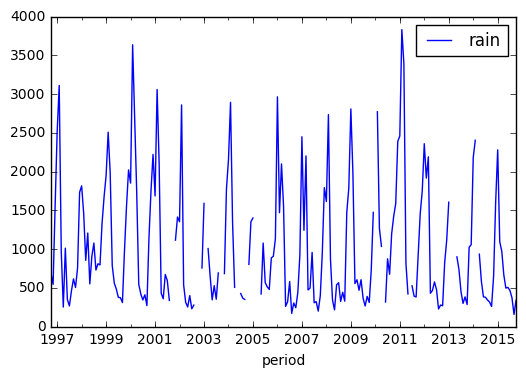

In [60]:
brazil_table.loc[brazil_table['rain']<0,'rain'] = None
brazil_table.plot(y='rain')

In [61]:
def rain_plot_per_country(countries_list,rain_array,index_table):
    for country in countries_list:
        masks = compute_countries_mask(country,worldmap)
        mask = masks[country]
        rain_masked = rain_per_country(mask,rain_array)
        monthly_rain = np.sum(rain_masked,axis=0).sum(axis=0)
        index_table[country] = monthly_rain
        index_table.loc[index_table[country]<0,country] = None
    return index_table

# rain_table = index_table.copy()
# rain_plot_per_country(countries_list,rain_array,rain_table)
# rain_table.head()

file  missing_value   units  \
period                                                                          
1996-10  gpcp_1dd_v1.2_p1d.199610_data_monthlyMean.npy       -99999.0  mm/day   
1996-11  gpcp_1dd_v1.2_p1d.199611_data_monthlyMean.npy       -99999.0  mm/day   
1996-12  gpcp_1dd_v1.2_p1d.199612_data_monthlyMean.npy       -99999.0  mm/day   
1997-01  gpcp_1dd_v1.2_p1d.199701_data_monthlyMean.npy       -99999.0  mm/day   
1997-02  gpcp_1dd_v1.2_p1d.199702_data_monthlyMean.npy       -99999.0  mm/day   

          Andorra  United Arab Emirates  Afghanistan  Antigua & Barbuda  \
period                                                                    
1996-10  1.677067              0.078344    34.225282                0.0   
1996-11  6.148998              1.486772    15.514168                0.0   
1996-12  3.692237              0.376295     9.636306                0.0   
1997-01  3.798235              3.859689    70.544409                0.0   
1997-02  0.887795              0.539611    43.052340                0.0   

         Anguilla    Albania   Armenia     ...      Virgin Is.     Vietnam  \
period                                     ...                               
1996-10       0.0  16.039108  5.706463     ...             0.0  253.385969   
1996-11       0.0  23.696808  0.996643     ...             0.0  249.204350   
1996-12       0.0  25.725250  6.930402     ...             0.0   55.228222   
1997-01       0.0   7.485341  3.797156     ...             0.0   18.002078   
1997-02       0.0   8.682489  6.290254     ...             0.0   36.586969   

          Vanuatu  Wallis & Futuna  Samoa      Yemen  Mayotte  South Africa  \
period                                                                        
1996-10  1.689113              0.0    0.0  10.300040      0.0    203.470707   
1996-11  4.792053              0.0    0.0   5.818371      0.0    445.085034   
1996-12  4.897659              0.0    0.0  13.464840      0.0    307.584240   
1997-01  8.773965              0.0    0.0   8.168350      0.0    322.086653   
1997-02  4.861371              0.0    0.0   5.957604      0.0    180.350185   

             Zambia    Zimbabwe  
period                           
1996-10   14.934690    5.142442  
1996-11  210.629053  110.898293  
1996-12  449.687901  122.482006  
1997-01  546.070129  292.813282  
1997-02  488.340979  172.068119  

[5 rows x 238 columns]

In [76]:
rain_table.to_csv('data/countries_rain.csv',index=True)
# import pandas
# rain_table = pandas.read_csv('data/countries_rain.csv')

In [70]:
rain_table['period'] = index_table.index
rain_table.set_index('period',inplace=True)

In [78]:
pandas.concat([rain_table.head(),rain_table.tail()])

file  missing_value   units  \
period                                                                          
1996-10  gpcp_1dd_v1.2_p1d.199610_data_monthlyMean.npy       -99999.0  mm/day   
1996-11  gpcp_1dd_v1.2_p1d.199611_data_monthlyMean.npy       -99999.0  mm/day   
1996-12  gpcp_1dd_v1.2_p1d.199612_data_monthlyMean.npy       -99999.0  mm/day   
1997-01  gpcp_1dd_v1.2_p1d.199701_data_monthlyMean.npy       -99999.0  mm/day   
1997-02  gpcp_1dd_v1.2_p1d.199702_data_monthlyMean.npy       -99999.0  mm/day   
2015-06  gpcp_1dd_v1.2_p1d.201506_data_monthlyMean.npy       -99999.0  mm/day   
2015-07  gpcp_1dd_v1.2_p1d.201507_data_monthlyMean.npy       -99999.0  mm/day   
2015-08  gpcp_1dd_v1.2_p1d.201508_data_monthlyMean.npy       -99999.0  mm/day   
2015-09  gpcp_1dd_v1.2_p1d.201509_data_monthlyMean.npy       -99999.0  mm/day   
2015-10  gpcp_1dd_v1.2_p1d.201510_data_monthlyMean.npy       -99999.0  mm/day   

          Andorra  United Arab Emirates  Afghanistan  Antigua & Barbuda  \
period                                                                    
1996-10  1.677067              0.078344    34.225282                0.0   
1996-11  6.148998              1.486772    15.514168                0.0   
1996-12  3.692237              0.376295     9.636306                0.0   
1997-01  3.798235              3.859689    70.544409                0.0   
1997-02  0.887795              0.539611    43.052340                0.0   
2015-06  2.270938              0.150582    15.319678                0.0   
2015-07  1.264782              0.301546    26.081410                0.0   
2015-08  2.856482              0.130100    16.531442                0.0   
2015-09  2.238747              0.332157    26.689964                0.0   
2015-10  0.877063              0.149418    27.020743                0.0   

         Anguilla    Albania    Armenia     ...      Virgin Is.     Vietnam  \
period                                      ...                               
1996-10       0.0  16.039108   5.706463     ...             0.0  253.385969   
1996-11       0.0  23.696808   0.996643     ...             0.0  249.204350   
1996-12       0.0  25.725250   6.930402     ...             0.0   55.228222   
1997-01       0.0   7.485341   3.797156     ...             0.0   18.002078   
1997-02       0.0   8.682489   6.290254     ...             0.0   36.586969   
2015-06       0.0   9.196781   5.856743     ...             0.0  224.797064   
2015-07       0.0   0.875363   1.447415     ...             0.0  305.571543   
2015-08       0.0   5.671548   5.333275     ...             0.0  271.301036   
2015-09       0.0  12.728715   2.330341     ...             0.0  315.693983   
2015-10       0.0  20.882679  14.109291     ...             0.0  165.748990   

          Vanuatu  Wallis & Futuna  Samoa      Yemen  Mayotte  South Africa  \
period                                                                        
1996-10  1.689113              0.0    0.0  10.300040      0.0    203.470707   
1996-11  4.792053              0.0    0.0   5.818371      0.0    445.085034   
1996-12  4.897659              0.0    0.0  13.464840      0.0    307.584240   
1997-01  8.773965              0.0    0.0   8.168350      0.0    322.086653   
1997-02  4.861371              0.0    0.0   5.957604      0.0    180.350185   
2015-06  0.998331              0.0    0.0  14.211992      0.0     92.012814   
2015-07  2.291315              0.0    0.0  13.653448      0.0    104.506362   
2015-08  2.112721              0.0    0.0  28.493728      0.0     50.682278   
2015-09  0.166005              0.0    0.0  14.847594      0.0    109.372406   
2015-10  0.341737              0.0    0.0   7.113398      0.0     66.764947   

             Zambia    Zimbabwe  
period                           
1996-10   14.934690    5.142442  
1996-11  210.629053  110.898293  
1996-12  449.687901  122.482006  
1997-01  546.070129  292.813282  
1997-02  488.340979  172.068119  
2015-06    0.620747    0.290451  
2015-0

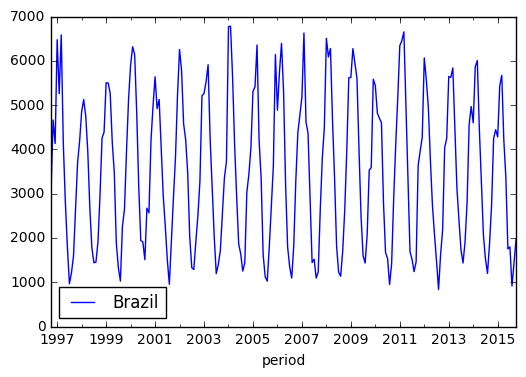

In [79]:
rain_table.plot(y='Brazil')

In [85]:
rain_table.drop(['file','missing_value','units'],axis=1,inplace=True)
rain_table_T = rain_table.transpose()
rain_table_T.describe(include='all')

period      1996-10      1996-11      1996-12      1997-01      1997-02  \
count    235.000000   235.000000   235.000000   235.000000   235.000000   
mean     137.025470   143.217097   130.866375   143.111544   140.587778   
std      458.298498   531.757729   478.264373   561.529693   520.793287   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%        0.000000     0.000000     0.000000     0.000000     0.000000   
50%       14.011708    10.989383     7.552308     7.485341     7.250704   
75%       63.966026    65.178854    53.059158    45.044544    36.702080   
max     4326.255742  4783.914763  4224.267605  6476.552430  5258.139721   

period      1997-03      1997-04      1997-05      1997-06      1997-07  \
count    235.000000   235.000000   235.000000   235.000000   235.000000   
mean     136.358225   137.097919   132.760281   152.689958   150.920350   
std      549.272361   465.312820   459.669441   549.677272   559.219394   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%        0.000000     0.000000     0.000000     0.000000     0.000000   
50%        9.468117    15.833647    14.440721    13.683326    11.266300   
75%       71.997921    78.705985    82.251661    96.499551    74.308947   
max     6583.165366  4144.937453  4314.531924  5500.232840  5758.351857   

period     ...           2015-01      2015-02      2015-03      2015-04  \
count      ...        235.000000   235.000000   235.000000   235.000000   
mean       ...        131.603697   126.445182   128.936373   124.283678   
std        ...        464.122756   475.658852   476.960666   440.455268   
min        ...          0.000000     0.000000     0.000000     0.000000   
25%        ...          0.000000     0.000000     0.000000     0.000000   
50%        ...          6.620517     7.730415     9.749594     9.228572   
75%        ...         46.509087    51.223725    73.228285    64.957845   
max        ...       4281.434122  5435.924726  5672.510838  4212.049207   

period      2015-05      2015-06      2015-07      2015-08      2015-09  \
count    235.000000   235.000000   235.000000   235.000000   235.000000   
mean     135.997622   144.015454   159.679522   154.172955   139.222624   
std      481.123576   550.493210   630.005366   576.698309   492.842868   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%        0.000000     0.000000     0.000000     0.000000     0.000000   
50%       11.353614     9.196781     7.046932    11.626936    14.847594   
75%       65.074897    75.745807    72.415779    69.697427    77.402025   
max     4082.182742  6022.488390  7041.504191  6245.260831  4987.831413   

period      2015-10  
count    235.000000  
mean     126.690024  
std      457.191719  
min        0.000000  
25%        0.000000  
50%       17.345562  
75%       77.746795  
max     5289.682976  

[8 rows x 229 columns]

In [88]:
import pandas
period = pandas.Period('2000-05')
period in rain_table_T.columns

True

In [86]:
worldmap_rain = worldmap.copy()
worldmap_rain.set_index('name',inplace=True)
print len(worldmap_rain),len(rain_table_T)
assert False
pandas.concat(worldmap_rain,rain_table_T)
for cn,ca in areas.iteritems():
    worldmap.loc[worldmap['name']==cn,'area'] = ca

536 235


AssertionError: 

In [124]:
def plot_worldmap_rain(country_names, year_month, rain_table, worldmap):
    '''
    Input:
     - country_names : list of strings
         List with country names to plot
     - year_month : tuple of integers
         Tuple with year and month number. Ex: (2010,12)
     - rain_table: ~pandas.DataFrame
     - worldmap : ~pandas.DataFrame
    '''
    import pandas
    period = pandas.Period('-'.join(year_month))
    if not period in rain_table:
        print 'Period {} not available in "rain_table"'.format(period)
        return None
    world_map_rain = worldmap.copy()
#     world_map_rain[str(period)] = None
    world_map_rain['rain'] = None
    for ind,row in rain_table.iterrows():
#         world_map_rain.loc[world_map_rain['name']==ind,str(period)] = row[period]
        world_map_rain.loc[world_map_rain['name']==ind,'rain'] = row[period]
    
    # Data source
    from bokeh.models import ColumnDataSource
    country_map = world_map_rain.loc[world_map_rain['name'].isin(country_names)]
    source_map = ColumnDataSource(country_map)

    # Plot setup
    from bokeh.plotting import figure
    # the colormap..
    from bokeh.models import LogColorMapper,LinearColorMapper
    from bokeh.palettes import Blues9 as palette
    palette.reverse()
    color_mapper = LogColorMapper(palette=palette)
    # the canvas..
    TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"
    p = figure( plot_height=500, plot_width=900,
                toolbar_location="left", tools=TOOLS,
                x_axis_type=None, y_axis_type=None)

    # The plot itself..
    p.patches(xs=world_map_rain['lons'], ys=world_map_rain['lats'],
              fill_color="white", fill_alpha=0,
              line_color="black", line_width=0.2)

    p.patches('lons','lats',source=source_map,
              fill_color={'field':'rain', 'transform':color_mapper},
              fill_alpha=0.5, line_color="white", line_width=0.5)
    
    from bokeh.models import HoverTool
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("Name", "@name"),
        ("Rain", "@rain mm/day"),
        ("(Long, Lat)", "($x, $y)"),
    ]


    return p

In [129]:
p = plot_worldmap_rain(countries_list,['2000','02'],rain_table_T,worldmap)

In [130]:
show(p)